# **Proceso de Selección de Características: Matriz de Correlación**


------------------------------------------------------------
 Nombre del archivo  : step01_correlationMatrixFeatures_sEMGnomMinMaxForSubjectFFCLE_.ipynb

 Autor               :   Jonathan Eduardo Castilla Zamora

 Github              :   https://github.com/JonathanCastilla/sEMG-RealTime-PatternRecognition-for-GripperControl

 Institución         :   Instituto Politécnico Nacional (IPN)

 Fecha de creación   :   Febrero/2025

 Última modificación :   Junio/2025

 Versión             :   1.3.1

 Descripción         :    El empleo de la Matriz de Correlación para el Reconocimiento de Patrones se conjetura a partir de la definición de un umbral o nivel de tolerancia a la redundancia (entendiéndose, asociación lineal) elegido por el usuario. La ejecución de este algoritmo dará como resultado la lista de los nombres de las características a utilizar para exportar y obtener el conjunto de características para su reducción en dimensión del número de variables correlacionadas por debajo del umbral definido permitiendo resumir este conjunto de datos con un menor número de variables representativas que explican colectivamente la mayor parte de la variabilidad del conjunto discriminado por la Matriz de Correlación mediante el Análisis de Componentes Principales (PCA)
                        


------------------------------------------------------------


## Importación de bibliotecas

In [ ]:
import pandas as pd # Importa la biblioteca pandas para la manipulación y análisis de estructuras de datos, especialmente DataFrames.
import numpy as np # Importa la biblioteca numpy para operaciones matemáticas avanzadas y manejo de arrays multidimensionales.
import seaborn as sns # Importa seaborn, una biblioteca de visualización basada en matplotlib, especializada en gráficos estadísticos.
# Se utiliza aquí principalmente para generar la matriz de correlación con mapas de calor (heatmaps).
import matplotlib.pyplot as plt # Importa matplotlib.pyplot, una biblioteca de visualización de gráficos en 2D.
from sklearn.preprocessing import MinMaxScaler # Importa MinMaxScaler de scikit-learn, una herramienta de preprocesamiento que normaliza los datos
# reescalando cada característica al rango [0, 1]. Esto puede mejorar la interpretación de la matriz de correlación.

## Definición de los archivos de datos correspondientes a cada gesto de muñeca para cada canal analógico:


* Extensor Común de los Dedos (EDC)

* Flexor Superficial de los Dedos (FDS)




### Protocolo de adquisición: M5sec

In [ ]:
# Definición de los archivos de datos correspondientes a cada gesto para ambos músculos (EDC y FDS)
# Archivos de datos M5sec
archivoWF_EDC_M5 = '/content/datosSensor_MAD_EDC_WF_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Wrist Flexion (WF) - Músculo EDC
archivoWF_FDS_M5 = '/content/datosSensor_MAD_FDS_WF_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Wrist Flexion (WF) - Músculo FDS
archivoWE_EDC_M5 = '/content/datosSensor_MAD_EDC_WE_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Wrist Extension (WE) - Músculo EDC
archivoWE_FDS_M5 = '/content/datosSensor_MAD_FDS_WE_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Wrist Extension (WE) - Músculo FDS
archivoHC_EDC_M5 = '/content/datosSensor_MAD_EDC_HC_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Hand Close (HC) - Músculo EDC
archivoHC_FDS_M5 = '/content/datosSensor_MAD_FDS_HC_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Hand Close (HC) - Músculo FDS

### Protocolo de adquisición: M3sec

In [ ]:
# Archivos de datos M3sec
archivoWF_EDC_M3 = '/content/datosSensor_MAD_EDC_WF_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Wrist Flexion (WF) - Músculo EDC
archivoWF_FDS_M3 = '/content/datosSensor_MAD_FDS_WF_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Wrist Flexion (WF) - Músculo FDS
archivoWE_EDC_M3 = '/content/datosSensor_MAD_EDC_WE_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Wrist Extension (WE) - Músculo EDC
archivoWE_FDS_M3 = '/content/datosSensor_MAD_FDS_WE_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Wrist Extension (WE) - Músculo FDS
archivoHC_EDC_M3 = '/content/datosSensor_MAD_EDC_HC_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Hand Close (HC) - Músculo EDC
archivoHC_FDS_M3 = '/content/datosSensor_MAD_FDS_HC_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_allFeatures_gestos_dataSet.csv' # Movimiento Hand Close (HC) - Músculo FDS

### Archivos CSV unificados de características para ambos canales analógicos (EDC y FDS)

In [ ]:
# Archivos de reposo
archivoREP_EDC = '/content/reposo_EDC_unificado_dataSet.csv'
archivoREP_FDS = '/content/reposo_FDS_unificado_dataSet.csv'

## Normalización de vectores de características de las matrices resultantes del proceso de Extracción de Características mediante propuesta de recorridos de ventana y porcentajes de solapamiento

### Declaración de función para Normalización tipo MinMax

In [ ]:
# Función para normalizar cada columna de una matriz de manera independiente
def normalize_columns(matrix):
    # If the input is a DataFrame, convert it to a NumPy array
    if isinstance(matrix, pd.DataFrame):
        matrix = matrix.to_numpy()

    # Crear una copia de la matriz para no modificar la original
    normalized_matrix = np.zeros_like(matrix, dtype=float)

    # Recorrer cada columna y normalizarla
    for col in range(matrix.shape[1]):
        scaler = MinMaxScaler()
        normalized_matrix[:, col] = scaler.fit_transform(matrix[:, col].reshape(-1, 1)).flatten()

    return normalized_matrix

## Preparación de los archivos CSV obtenidos de la extracción de características.



1. Tras la carga de datos, se elimina la primera columna, que corresponde al
índice o  número de muestra (número de ventana de recorrido de extracción en particular), esto se realiza dado que esta información no aporta ninguna métrica discriminativa para el algoritmo de Matriz de Correlación. De igual forma, el conjunto de datos se convierten en matrices NumPy para facilitar su manipulación posterior.

2. Subsecuentemente, se determina la mínima cantidad de muestras (valores de las
 ventanas de características extraídas) entre todos los gestos y músculos para asegurar que cada clase contenga el mismo número de ejemplos, evitando errores en el proceso de datos por desbalance de número de datos por lo que los conjuntos de características se recortan a dicho tamaño para, después, concatenarse verticalmente para formar dos matrices completas: una para el músculo Extensor Digitorum Communis (EDC) y otra para el músculo Flexor Digitorum Superficialis (FDS).


In [ ]:
# Cargar archivos en DataFrames
WF_EDC = pd.concat([
    pd.read_csv(archivoWF_EDC_M5),
    pd.read_csv(archivoWF_EDC_M3)
], ignore_index=True)

WF_FDS = pd.concat([
    pd.read_csv(archivoWF_FDS_M5),
    pd.read_csv(archivoWF_FDS_M3)
], ignore_index=True)

WE_EDC = pd.concat([
    pd.read_csv(archivoWE_EDC_M5),
    pd.read_csv(archivoWE_EDC_M3)
], ignore_index=True)

WE_FDS = pd.concat([
    pd.read_csv(archivoWE_FDS_M5),
    pd.read_csv(archivoWE_FDS_M3)
], ignore_index=True)

HC_EDC = pd.concat([
    pd.read_csv(archivoHC_EDC_M5),
    pd.read_csv(archivoHC_EDC_M3)
], ignore_index=True)

HC_FDS = pd.concat([
    pd.read_csv(archivoHC_FDS_M5),
    pd.read_csv(archivoHC_FDS_M3)
], ignore_index=True)

# Reposo se mantiene igual
REP_EDC = pd.read_csv(archivoREP_EDC)
REP_FDS = pd.read_csv(archivoREP_FDS)

# Extraer características
caracteristicas = WF_EDC.columns[1:].tolist()
print("Características:", caracteristicas)

# Eliminar primera columna (número de muestra)
WF_EDC = WF_EDC.iloc[:, 1:]
WF_FDS = WF_FDS.iloc[:, 1:]
WE_EDC = WE_EDC.iloc[:, 1:]
WE_FDS = WE_FDS.iloc[:, 1:]
HC_EDC = HC_EDC.iloc[:, 1:]
HC_FDS = HC_FDS.iloc[:, 1:]
REP_EDC = REP_EDC.iloc[:, 1:]
REP_FDS = REP_FDS.iloc[:, 1:]

# Convertir a matrices NumPy
matrices_EDC = [WF_EDC.to_numpy(), WE_EDC.to_numpy(), HC_EDC.to_numpy(), REP_EDC.to_numpy()]
matrices_FDS = [WF_FDS.to_numpy(), WE_FDS.to_numpy(), HC_FDS.to_numpy(), REP_FDS.to_numpy()]

# Determinar mínimo de filas
min_filas = min(mat.shape[0] for mat in matrices_EDC + matrices_FDS)

# Recortar todas al mínimo
matrices_EDC = [mat[:min_filas, :] for mat in matrices_EDC]
matrices_FDS = [mat[:min_filas, :] for mat in matrices_FDS]

# Concatenar verticalmente
P_EDC = np.vstack(matrices_EDC)
P_FDS = np.vstack(matrices_FDS)

print("Forma final P_EDC:", P_EDC.shape)
print("Forma final P_FDS:", P_FDS.shape)

Características: ['MAV', 'WL', 'MWL', 'SCC', 'ZC', 'IEMG', 'SSI', 'Mean', 'Variance', 'SD', 'RMS', 'WAMP', 'AAC', 'Skewness', 'Kurtosis', 'DASDV', 'MMAV1', 'MMAV2', 'MAX', 'RSSL']
Forma final P_EDC: (26360, 20)
Forma final P_FDS: (26360, 20)


In [ ]:
# Guardar la matriz en un archivo CSV
np.savetxt("matriz_EDC.csv", P_EDC, delimiter=",", fmt="%.6f")

In [ ]:
from google.colab import files

# Descargar el archivo
files.download("matriz_EDC.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Unificación global y normalización de tipo MinMaxScaler por característica de las matrices de características para ambos canales analógicos (EDC y FDS).

### Concatenación de características sin importar su canal analógico

Las matrices de características asociadas a ambos canales analógicos (FDS y EDC) se concatenan en una sola matriz, este es la última unificación de los conjuntos de datos, representando la fusión de información de los valores de las ventanas de recorrido resultantes del proceso de extracción de características debidamente ordenadas por características de las señales sEMG multicanal.

Cabe ser mencionado, como paso adicional, que a esta matriz global se le deci de una normalización de tipo MinMaxScaler a cada columna, es decir, a todo el vector de un tipo de característica, garantizando que los valores de cada columna se encuentren en un rango de R : [0,1]. Este paso resulta crucial ilustrarlo en la medida de que, pese a que la extracción de características procede a muestras ya normalizadas de tipo MinMaxScaler por sujeto (específicamente, del tipo de post procesamiento Feed Forward Comb (FFC) con Envolvente Lineal obtenido desde el microcontrolador ESP32), esto no garantiza dada la naturaleza de las diferentes características al calcularse que los valores de las ventanas de recorrido extraídas estén acotados en el rango R : [0,1], al contrario, dependiendo del tipo de característica en particular pueden superar el valor de la unidad o estar por debajo de la unidad en el valor máximo encontrado del todo conjunto de datos. Es por ello que, al realizar nuevamente la normalización de tipo MinMaxScaler de los valores de las ventanas de recorrido asociada a cada característica en particular, no sólo se garantiza que se encuentren acotadas a dicho rango, sino que se asegura para el proceso de entrenamiento para el clasificador de Aprendizaje Automático (Machine Learning) de tipo supervisado ninguna característica predomine sobre otra durante el entrenamiento, esta consideración se analizará más adelante.

In [ ]:
# Concatenación de características de ambos músculos en una sola matriz de datos
data = np.vstack((P_EDC, P_FDS))
# Aplicar normalización MinMaxScaler de los datos concatenados por característica
data = normalize_columns(data)
print(f"\nForma de los conjuntos de datos totales:")
print(f"P_EDC: {P_EDC.shape}")
print(f"P_FDS: {P_FDS.shape}")
print(f"data: {data.shape}")
# print(data)


Forma de los conjuntos de datos totales:
P_EDC: (26360, 20)
P_FDS: (26360, 20)
data: (52720, 20)


In [ ]:
# Guardar la matriz en un archivo CSV
np.savetxt("matriz.csv", data, delimiter=",", fmt="%.6f")

In [ ]:
from google.colab import files

# Descargar el archivo
files.download("matriz.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Manejo de valores no definidos (NaN) obtenidos en el proceso de extracción de características y exportación en archivos CSV.

Posteriormente, se realizó una verificación como imputación de datos no definidos (valores NaN), esto para corregir posibles errores en el cálculo de características de algoritmos previos en caso de presentarse. Este reemplazo de valores no definidos (NaN) se implementó mediante propagación hacia adelante (forward fill) y propagación hacia atrás (backward fill) que permite sustituir estos valores no definidas para una ventana en particular con el valor de una ventana previa o posterior, dado que los valores del conjunto de características para cada uno de los comandos (WF,WE, HC y REP) y por cada canal analógico (FDS y EDC) se encuentran ordenados en cuanto a la sucesión temporal de extracción de ventanas, es decir, considerando su orden cronológico; resultó posible emplear este método. Esta estrategia asegura la integridad del conjunto de datos, manteniendo la longitud de los vectores de características sin introducir distorsiones estadísticas significativas.

In [ ]:
def fill_nan_with_previous(data):
    """
    Reemplaza los valores NaN en cada columna por el valor anterior en esa misma columna.
    Si el primer valor es NaN, se utiliza el siguiente valor válido.

    Parámetros:
        data (numpy.ndarray): Matriz de datos con posibles NaN.

    Retorna:
        numpy.ndarray: Matriz con los NaN reemplazados.
    """
    df = pd.DataFrame(data)
    df_filled = df.fillna(method='ffill').fillna(method='bfill')
    return df_filled.to_numpy()

In [ ]:
data = fill_nan_with_previous(data)

<ipython-input-8-5d0a3097ae74>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df.fillna(method='ffill').fillna(method='bfill')


## Comprobación de Normalización MinMax para cada vector de características

In [ ]:
def get_min_max(data):
    """
    Obtiene los valores mínimos y máximos de cada columna (característica) en el conjunto de datos.

    Parámetros:
        data (numpy.ndarray): Matriz de datos donde cada fila es un segmento y cada columna es una característica.

    Retorna:
        min_values (numpy.ndarray): Array con los valores mínimos de cada columna.
        max_values (numpy.ndarray): Array con los valores máximos de cada columna.
    """
    min_values = np.min(data, axis=0)  # Mínimo de cada columna
    max_values = np.max(data, axis=0)  # Máximo de cada columna
    return min_values, max_values

In [ ]:
min_values, max_values = get_min_max(data)

print("Valores mínimos de cada característica:", min_values)
print("Valores máximos de cada característica:", max_values)

Valores mínimos de cada característica: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valores máximos de cada característica: [1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


## Matriz de Correlación (Coeficiente de Pearson) de todas las características, discriminación previa de vectores de características por naturaleza del tipo de postprocesamiento empleado (Filtro Feed Forward Comb (FFC) con Envolvente Lineal (LE) obtenido del microcontrolador ESP32)

Para esta tarea en particular, se decidió generar un DataFrame con nombres asig
nados a las columnas (nombres de las características a lo que aluden los valores
 de los vectores), y se eliminan explícitamente algunas características seleccionadas a priori, esto dada la naturaleza de la selección del postprocesamiento empleado, particularmente al tratarse del uso de la señal la envolvente lineal de la señal sEMG con Filtro Feed Forward Comb (FFC) procesado en el microcontrolador ESP32, este tipo de procesamiento está definido en el conjunto de los números: sEMG_minMax_FFC_LE_ESP32 ∈ Z+, por lo que no posee valores negativos ni cruces por ceros así como que la señal está definida por valores absolutos dado que se extrajo la envolvente lineal (LE), por lo que, en primera instancia es posible descartar el uso de estas características que resultan redundantes con otras obtenidas o que simplemente dan un vector nulo.

 Este primer proceso de discriminación a priori de las características resultó en el descarte de las siguientes características previas al algoritmo de Matriz de Correlación:
 i) SCC (Signal Change Complexity): Complejidad del cambio de la señal.
 ii) WAMP (Waveform Amplitude Slope): Contador de amplitud de la señal.
 iii) ZC (Zero Crossings): Número de cruces por cero de la señal.
 iv) MAV (Mean Absolute Value): Valor medio absoluto de la señal.

Tras esta primera discriminación de características, se procede a calcularla matriz de correlación de Pearson entre todas las características, calculando la correlación entre pares de características. Cabe ser mencionado que esta matriz cuantifica el grado de relación lineal entre pares de características. En este sentido, se estableció un umbral de correlación, es decir, un nivel de tolerancia a la asociación lineal, en el que si el resultado del coeficiente de Pearson se describe por encima del mismo se considera que dos características contienen información redundante.

Finalmente, mediante un barrido doble (matriz triangular superior), se identifican aquellas características cuya correlación mutua excede el umbral declarado por el usuario. En particular, para cada par de variables (características) correlacionadas, una de las dos características es marcada para eliminación, en tanto que la otra se conserva. Tras la finalización de este proceso otorga como resultado un conjunto de características reducido cuales entre todas ellas se caracterizan de tener una asociación lineal a el coeficiente de Pearson definido por el usuario. Esto genera como resultado que cada una de las características por debajo de este umbral aportan información no redundante, es decir, los valores de estas características tienen baja asociación lineal otorgando información diferente de una misma ventana de recorrido de la segmentación de las muestras de las señales sEMG adquiridas y filtradas.

El empleo de este algoritmo permite complementar la reducción de la dimensionali
dad del conjunto de datos mediante el Análisis de Componentes Principales (PCA),
asegurando que las variables (características) a analizar describe completamente al conjunto colectivo de las muestras.

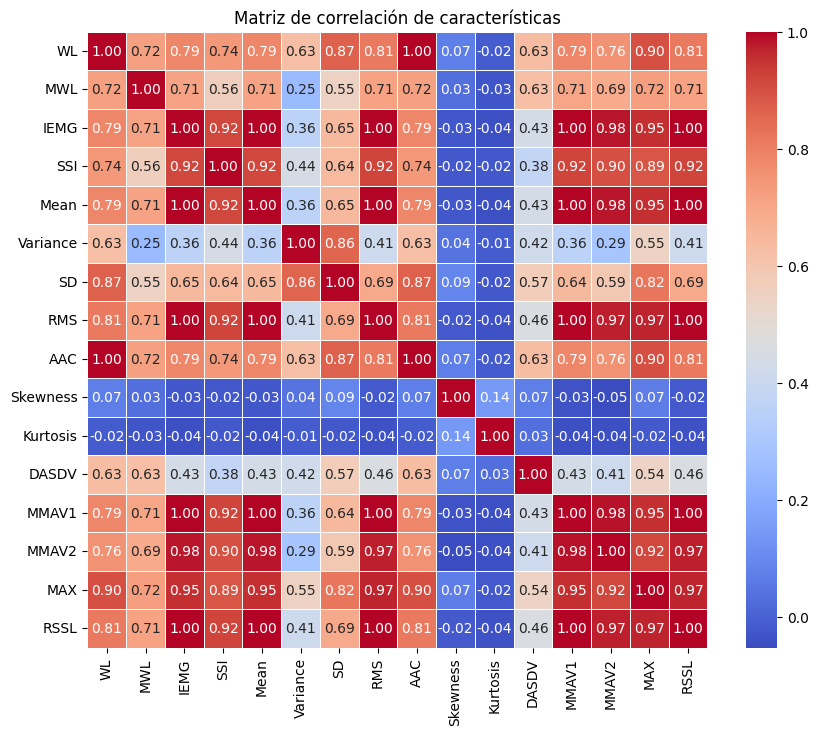

Se eliminaron 9 características por alta correlación.

Lista de características eliminadas y su reemplazo:
SD fue eliminada en favor de Variance
RMS fue eliminada en favor de Mean
AAC fue eliminada en favor de RMS
MAX fue eliminada en favor de MMAV2
RSSL fue eliminada en favor de MAX
SSI fue eliminada en favor de IEMG
Mean fue eliminada en favor de SSI
MMAV1 fue eliminada en favor de RMS
MMAV2 fue eliminada en favor de MMAV1
Características restantes: ['WL', 'MWL', 'IEMG', 'Variance', 'Skewness', 'Kurtosis', 'DASDV']

Forma original: (52720, 16), Forma después de filtrar: (52720, 7)


In [ ]:
# Crear nombres de características para ambos músculos
caracteristicas = [f"{c}" for c in caracteristicas]

# Asignar nombres de columnas al DataFrame
df = pd.DataFrame(data, columns=caracteristicas)

# Definir las características que no deben ser consideradas (por ejemplo, 'Mean' y 'SD')
caracteristicas_a_eliminar = ['SCC', 'WAMP', 'ZC', 'MAV']

# Eliminar las columnas que contienen 'Mean' y 'SD'
df = df.drop(columns=caracteristicas_a_eliminar)

# Definir el umbral de correlación para considerar características redundantes
# Valores típicos pueden ser 0.85 - 0.95 dependiendo del nivel de tolerancia a la redundancia
threshold = 0.8

# Calcular la matriz de correlación entre todas las características del DataFrame
# La correlación mide el grado de relación lineal entre pares de características
correlation_matrix = df.corr()

# Visualizar la matriz de correlación como un mapa de calor para identificar relaciones fuertes entre características
plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura para una mejor visualización
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación de características")  # Agregar título a la visualización
plt.show()

# Conjunto para almacenar los nombres de las características que serán eliminadas por redundancia
to_drop = set()

# Diccionario para almacenar la relación de características eliminadas y la que las sustituye
replacement_map = {}

# Recorrer la matriz de correlación para identificar características con alta correlación
for i in range(len(correlation_matrix.columns)):  # Iterar sobre cada característica
    for j in range(i + 1, len(correlation_matrix.columns)):  # Comparar con las características siguientes (evita duplicados)

        # Evaluar si la correlación entre dos características supera el umbral establecido
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_to_drop = correlation_matrix.columns[j]  # Característica redundante a eliminar
            colname_to_keep = correlation_matrix.columns[i]  # Característica que se mantendrá en el conjunto de datos

            to_drop.add(colname_to_drop)  # Agregar la característica redundante al conjunto de eliminadas
            replacement_map[colname_to_drop] = colname_to_keep  # Guardar la relación en el diccionario

# Crear un nuevo DataFrame sin las características redundantes
df_filtered = df.drop(columns=to_drop)

# Imprimir el número de características eliminadas y la relación de sustitución
print(f"Se eliminaron {len(to_drop)} características por alta correlación.")

print("\nLista de características eliminadas y su reemplazo:")
for dropped, kept in replacement_map.items():
    print(f"{dropped} fue eliminada en favor de {kept}")

print("Características restantes:", df_filtered.columns.tolist())

# Mostrar la dimensión del conjunto de datos antes y después del filtrado
print(f"\nForma original: {df.shape}, Forma después de filtrar: {df_filtered.shape}")